In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Data Preparation

In [ ]:
features = pd.read_csv(r"features.csv")
train = pd.read_csv(r"train.csv")
stores = pd.read_csv(r"stores.csv")
test = pd.read_csv(r"test.csv")
sample_submission = pd.read_csv(r"sampleSubmission.csv")

In [ ]:
#Extracting Date Information
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = (df.Date.dt.isocalendar().week)*1.0

feature_store = features.merge(stores, how='inner', on = "Store")

In [ ]:
train_df = train.merge(feature_store, how='inner',
                       on = ['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)
testing_train = train.merge(stores, how='left').merge(features, how='left')

split_date(train_df)
df_weeks = train_df.groupby('WeekOfYear').sum()

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

<ipython-input-47-c244d54d0ee3>:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:
train_df.shape

(421570, 20)

In [ ]:
train_df.describe().T

count           mean           std      min         25%  \
Store         421570.0      22.200546     12.785297      1.0        11.0   
Dept          421570.0      44.260317     30.492054      1.0        18.0   
Weekly_Sales  421570.0   15981.258123  22711.183519 -4988.94     2079.65   
Temperature   421570.0      60.090059     18.447931    -2.06       46.68   
Fuel_Price    421570.0       3.361027      0.458515    2.472       2.933   
MarkDown1     150681.0    7246.420196   8291.221345     0.27     2240.27   
MarkDown2     111248.0    3334.628621   9475.357325  -265.76        41.6   
MarkDown3     137091.0    1439.421384    9623.07829    -29.1        5.08   
MarkDown4     134967.0    3383.168256   6292.384031     0.22      504.22   
MarkDown5     151432.0    4628.975079   5962.887455   135.16     1878.44   
CPI           421570.0     171.201947     39.159276  126.064  132.022667   
Unemployment  421570.0       7.960289      1.863296    3.879       6.891   
Size          421570.0  136727.915739  60980.583328  34875.0     93638.0   
Year          421570.0    2010.968591      0.796876   2010.0      2010.0   
Month         421570.0        6.44951      3.243217      1.0         4.0   
Day           421570.0      15.673131      8.753549      1.0         8.0   
WeekOfYear    421570.0      25.826762     14.151887      1.0        14.0   

                    50%         75%         max  
Store              22.0        33.0        45.0  
Dept               37.0        74.0        99.0  
Weekly_Sales    7612.03  20205.8525   693099.36  
Temperature       62.09       74.28      100.14  
Fuel_Price        3.452       3.738       4.468  
MarkDown1       5347.45      9210.9    88646.76  
MarkDown2         192.0     1926.94   104519.54  
MarkDown3          24.6      103.99   141630.61  
MarkDown4       1481.31     3595.04    67474.85  
MarkDown5       3359.45      5563.8   108519.28  
CPI           182.31878  212.416993  227.232807  
Unemployment      7.866       8.572      14.313  
Size           140167.0    202505.0    219622.0  
Year             2011.0      2012.0      2012.0  
Month               6.0         9.0        12.0  
Day                16.0        23.0        31.0  
WeekOfYear         26.0        38.0        52.0

# Missing Value

In [ ]:
train_df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
Year                 0
Month                0
Day                  0
WeekOfYear           0
dtype: int64

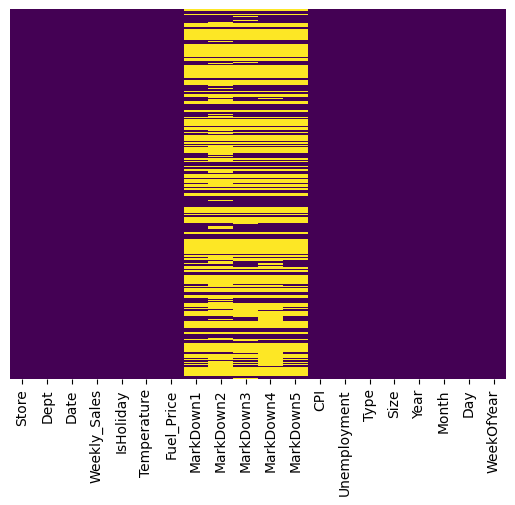

In [ ]:
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

# Popularity of Store Types

In [ ]:
typecounts = train_df.Type.value_counts().to_dict()
df = pd.DataFrame(list(typecounts.items()), columns=['Store_Type', 'Counts'])

fig = px.pie(df, values='Counts', names='Store_Type',
             title='Popularity of Store Types',labels='Store_Type')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# Average Sales - Store Type

In [ ]:
avgweeklysales = train_df.groupby('Type')['Weekly_Sales'].mean().to_dict()
df = pd.DataFrame(list(avgweeklysales.items()), columns=['Store_Type', 'AvgSales'])

fig = px.bar(df,
             x="Store_Type",
             y="AvgSales",
             title="Avergae Sales - Per Store",
             color_discrete_sequence=["#1f77b4"], template='plotly_white')
fig.show()

# Average Monthly Sales - Per Year

In [ ]:
sales2010 = train_df[(train_df.Year == 2010)].groupby('Month')['Weekly_Sales'].mean().to_dict()
df2010 = pd.DataFrame(list(sales2010.items()), columns=['Month', 'AvgSales2010'])

sales2011 = train_df[train_df.Year == 2011].groupby('Month')['Weekly_Sales'].mean().to_dict()
df2011 = pd.DataFrame(list(sales2011.items()), columns=['Month', 'AvgSales2011'])

sales2012 = train_df[train_df.Year == 2012].groupby('Month')['Weekly_Sales'].mean().to_dict()
df2012 = pd.DataFrame(list(sales2012.items()), columns=['Month', 'AvgSales2012'])

monthly_train_df = df2010.merge(df2011, how='right', on='Month').merge(df2012, how='left', on='Month')

# create trace1
trace1 = go.Bar(
                x = df2010.Month,
                y = df2010.AvgSales2010,
                name = "AvgSales2010")
# create trace2
trace2 = go.Bar(
                x = df2011.Month,
                y = df2011.AvgSales2011,
                name = "AvgSales2011")

# create trace3
trace3 = go.Bar(
                x = df2012.Month,
                y = df2012.AvgSales2012,
                name = "AvgSales2012")
data = [trace1, trace2, trace3]
layout = go.Layout(barmode = "group",
                   template='plotly_white',
                   xaxis_title="Month",
                   yaxis_title="Average Monthly Sales")
fig = go.Figure(data = data, layout = layout)
fig.update_xaxes( dtick=1)
fig.show()

# Average Weekly Sales - per Year

In [ ]:
weekly_sales = train_df.groupby(['Year','WeekOfYear'], as_index = False).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2010 = train_df.loc[train_df['Year']==2010].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2011 = train_df.loc[train_df['Year']==2011].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2012 = train_df.loc[train_df['Year']==2012].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = weekly_sales2010['Weekly_Sales']['mean'].index, y = weekly_sales2010['Weekly_Sales']['mean'], name = 'Average Sales 2010', mode = 'lines') )
fig.add_trace(go.Scatter( x = weekly_sales2011['Weekly_Sales']['mean'].index, y = weekly_sales2011['Weekly_Sales']['mean'], name = 'Average Sales 2011', mode = 'lines') )
fig.add_trace(go.Scatter( x = weekly_sales2012['Weekly_Sales']['mean'].index, y = weekly_sales2012['Weekly_Sales']['mean'], name = 'Average Sales 2012', mode = 'lines') )
fig.add_annotation(text="Thanksgiving", x=47, y=25000, showarrow=False)
fig.add_annotation(text="Christmas", x=51, y=29000, showarrow=False)
fig.update_layout(title = 'Sales 2010, 2011, 2012', xaxis_title = 'Weeks')

# Average Store Sales

In [ ]:
store_sales = train_df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)


fig = px.bar(store_sales,
             x=store_sales.index,
             y=store_sales.values,
             title="Average Sales - Per Store",
             labels={'x':'Stores', 'y':'Sales'},
             color_discrete_sequence=["#9467bd"], template='plotly_white')

fig.update_xaxes(tick0=1, dtick=1)

fig.show()

# Average Store Sales - Year Wise

In [ ]:
store_sales_2010 = train_df[train_df.Year==2010].groupby('Store')['Weekly_Sales'].mean().to_dict()
store2010_df = pd.DataFrame(list(store_sales_2010.items()), columns=['Store', 'AvgSales2010'])

store_sales_2011 = train_df[train_df.Year==2011].groupby('Store')['Weekly_Sales'].mean().to_dict()
store2011_df = pd.DataFrame(list(store_sales_2011.items()), columns=['Store', 'AvgSales2011'])

store_sales_2012 = train_df[train_df.Year==2012].groupby('Store')['Weekly_Sales'].mean().to_dict()
store2012_df = pd.DataFrame(list(store_sales_2012.items()), columns=['Store', 'AvgSales2012'])

fig = make_subplots(rows=3, cols=1, subplot_titles=("Average Store Sales 2010", "Average Store Sales 2011", "Average Store Sales 2012"))

fig.add_trace(go.Bar(x=store2010_df.Store, y=store2010_df.AvgSales2010,),1, 1)

fig.add_trace(go.Bar(x=store2011_df.Store, y=store2011_df.AvgSales2011,),2, 1)

fig.add_trace(go.Bar(x=store2012_df.Store, y=store2012_df.AvgSales2012,),3, 1)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), template='plotly_white', showlegend=False, height=1500)

fig.update_xaxes(title_text="Store", row=1, col=1)
fig.update_xaxes(title_text="Store", row=2, col=1)
fig.update_xaxes(title_text="Store", row=3, col=1)

fig.update_yaxes(title_text="AvgSales", row=1, col=1)
fig.update_yaxes(title_text="AvgSales", row=2, col=1)
fig.update_yaxes(title_text="AvgSales", row=3, col=1)

fig.update_xaxes(tick0=1, dtick=1)
fig.show()

# Holidays Vs Nonholidays Sales

In [ ]:
holiday_sales = train_df.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_counts = train_df.IsHoliday.value_counts()

fig = make_subplots(rows=1, cols=2, subplot_titles=("Holidays/Nonholidays Sales", "Holidays/Nonholidays Counts"))

fig.add_trace(go.Bar(x=holiday_sales.values, y=holiday_sales.index, orientation='h',),1, 1)

fig.add_trace(go.Bar(x=holiday_counts.values, y=holiday_counts.index, orientation='h',),1, 2)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), template='plotly_white', showlegend=False)
fig.show()

# Relationship: Markdowns vs Sales

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown1'], name = 'MarkDown1', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown2'], name = 'MarkDown2', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown3'], name = 'MarkDown3', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown4'], name = 'MarkDown4', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown5'], name = 'MarkDown5', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['Weekly_Sales'], name = 'Weekly Sales', mode = 'lines') )
fig.update_layout(title = "Sales vs Markdown's", xaxis_title = 'Weeks')


# Relationship: Temperature vs Sales

In [ ]:
# Converting the temperature to celsius for a better interpretation
train_df['Temperature'] = train_df['Temperature'].apply(lambda x :  (x - 32) / 1.8)
train_df['Temperature'] = train_df['Temperature'].apply(lambda x :  (x - 32) / 1.8)
train_plt = train_df.sample(frac=0.20)

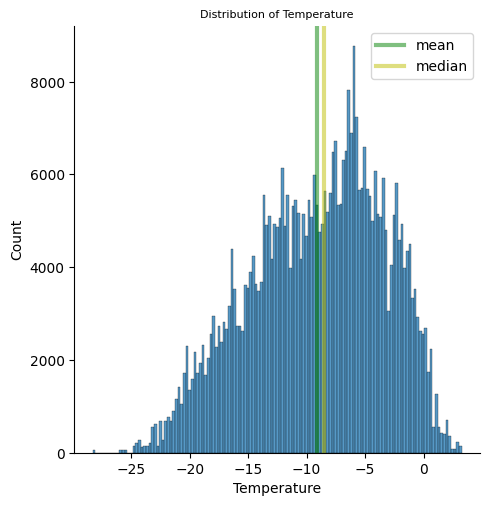

In [ ]:
sns.displot(train_df['Temperature'], kde=False)
plt.axvline(x=train_df.Temperature.mean(), linewidth=3, color='g', label="mean", alpha=0.5)
plt.axvline(x=train_df.Temperature.median(), linewidth=3, color='y', label="median", alpha=0.5)

plt.xlabel('Temperature')
plt.ylabel("Count")
plt.title("Distribution of Temperature", size=8)
plt.legend(["mean", "median"])
plt.show()

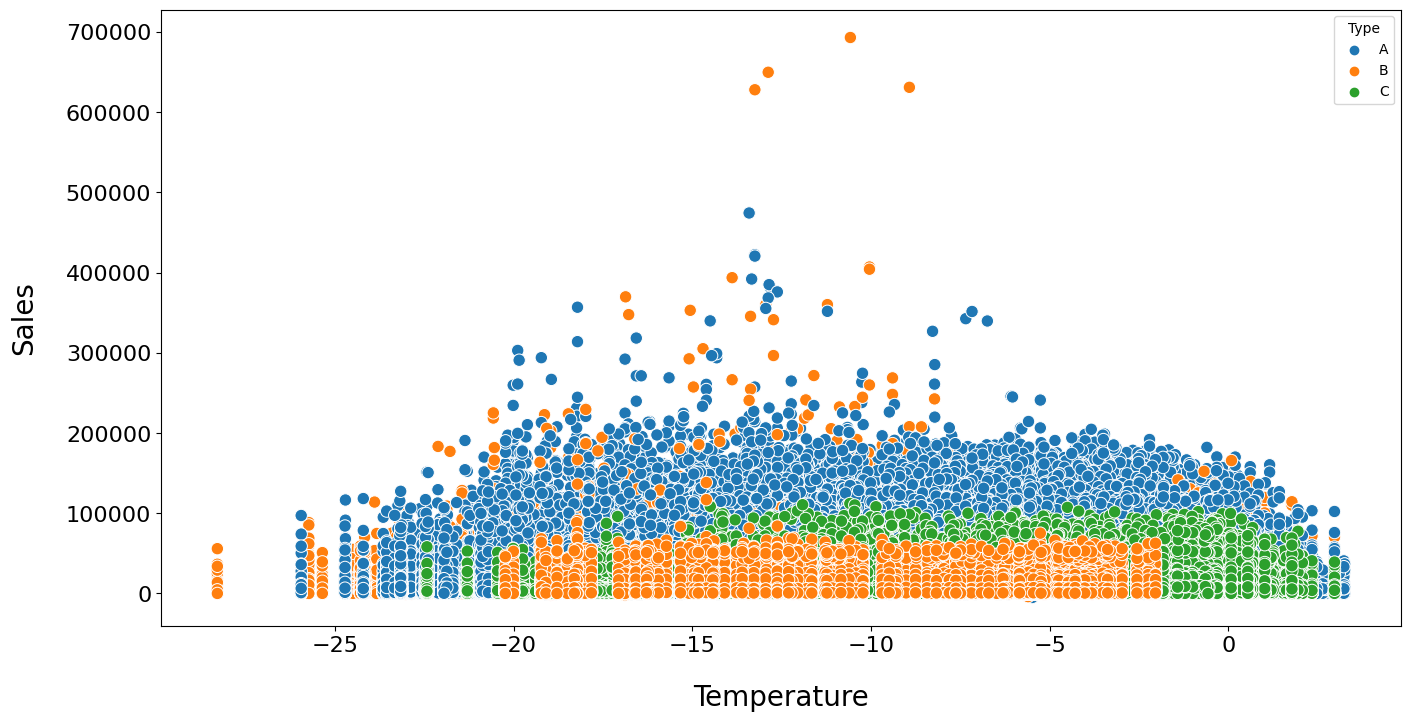

In [ ]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=train_df.Temperature, y=train_df.Weekly_Sales, hue=train_df.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Temperature', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

In [ ]:
px.histogram(train_plt, x='Temperature', y ='Weekly_Sales', color='IsHoliday', marginal='box', opacity= 0.6,
             title = 'Temperature and sales by holiday', color_discrete_sequence=['#636EFA', '#EF553B'])

Output hidden; open in https://colab.research.google.com to view.

# Relationship: Fuel Price vs Sales

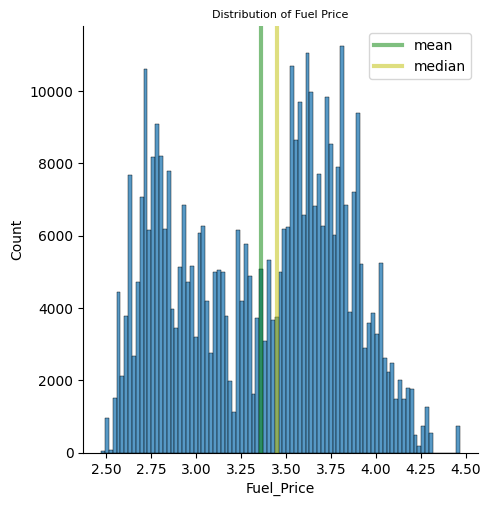

In [ ]:
sns.displot(train_df['Fuel_Price'], kde=False)
plt.axvline(x=train_df.Fuel_Price.mean(), linewidth=3, color='g', label="mean", alpha=0.5)
plt.axvline(x=train_df.Fuel_Price.median(), linewidth=3, color='y', label="median", alpha=0.5)

plt.xlabel('Fuel_Price')
plt.ylabel("Count")
plt.title("Distribution of Fuel Price", size=8)
plt.legend(["mean", "median"])
plt.show()

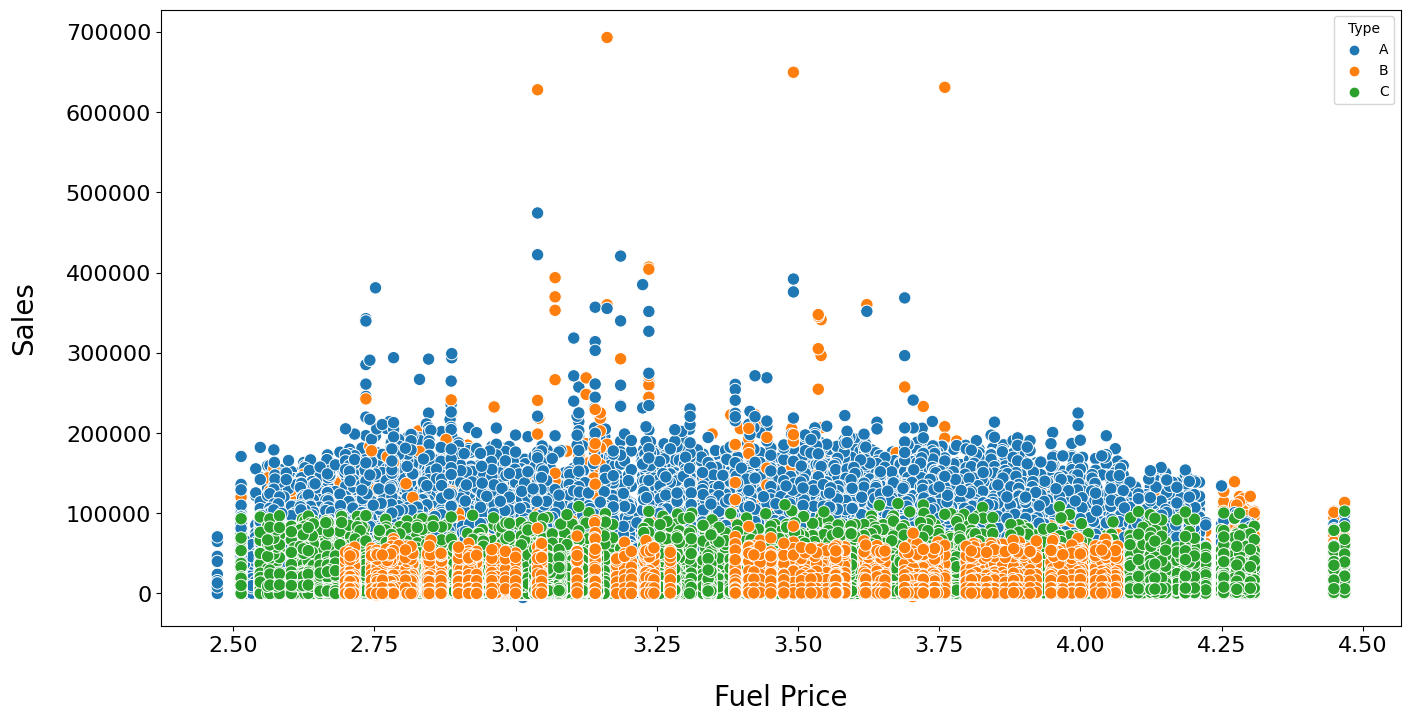

In [ ]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=train_df.Fuel_Price, y=train_df.Weekly_Sales, hue=train_df.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Fuel Price', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

In [ ]:
px.histogram(train_plt, x='Fuel_Price', y ='Weekly_Sales', color='IsHoliday', marginal='box', opacity= 0.6,
             title='Fuel price and sales by holiday',color_discrete_sequence=['#00CC96', '#AB63FA'])

# Relationship: CPI vs Sales

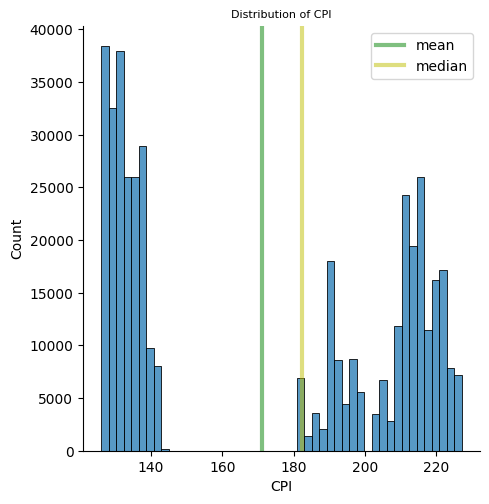

In [ ]:
sns.displot(train_df['CPI'], kde=False)
plt.axvline(x=train_df.CPI.mean(), linewidth=3, color='g', label="mean", alpha=0.5)
plt.axvline(x=train_df.CPI.median(), linewidth=3, color='y', label="median", alpha=0.5)

plt.xlabel('CPI')
plt.ylabel("Count")
plt.title("Distribution of CPI", size=8)
plt.legend(["mean", "median"])
plt.show()

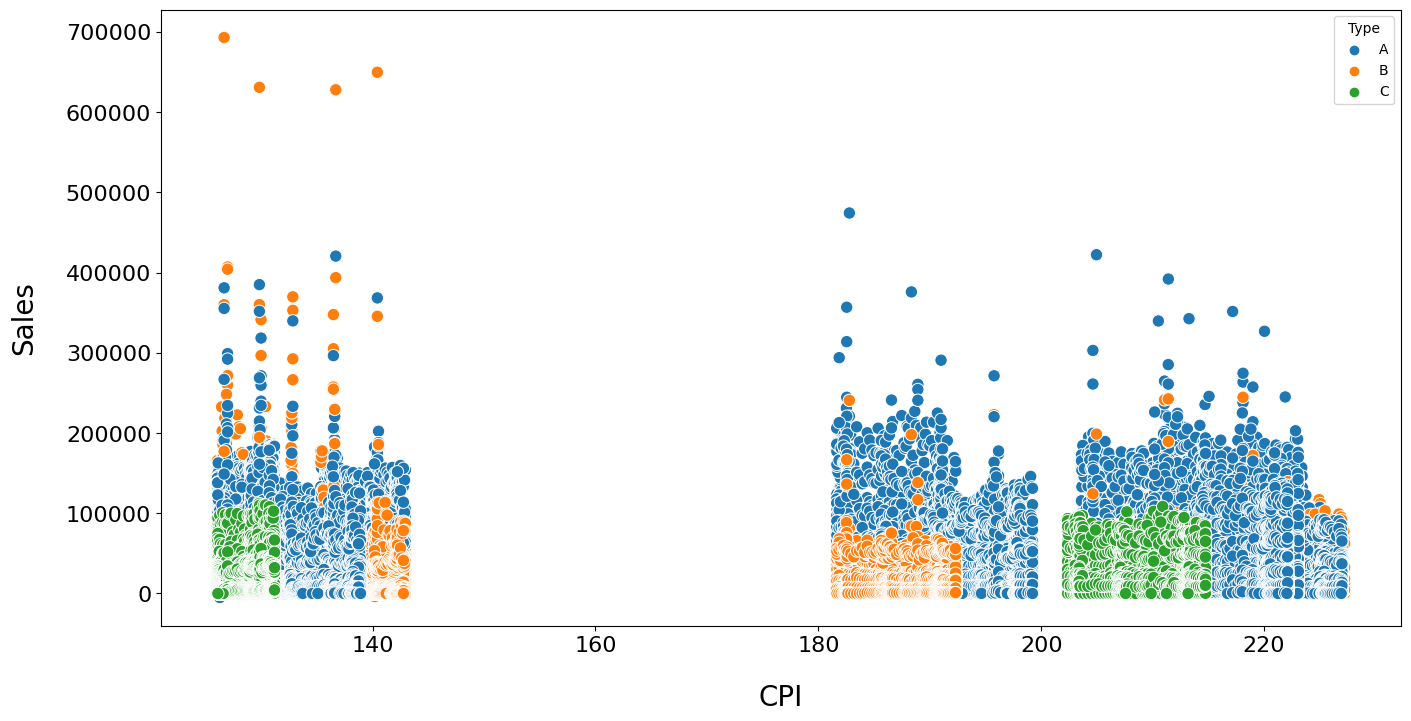

In [ ]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=train_df.CPI, y=train_df.Weekly_Sales, hue=train_df.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('CPI', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

In [ ]:
px.histogram(train_plt, x='CPI', y ='Weekly_Sales', color='IsHoliday', marginal='box', opacity= 0.6,
             title='CPI and sales by holiday',color_discrete_sequence=['#FFA15A', '#19D3F3'])

Output hidden; open in https://colab.research.google.com to view.

# Relationship: Unemployment vs Sales

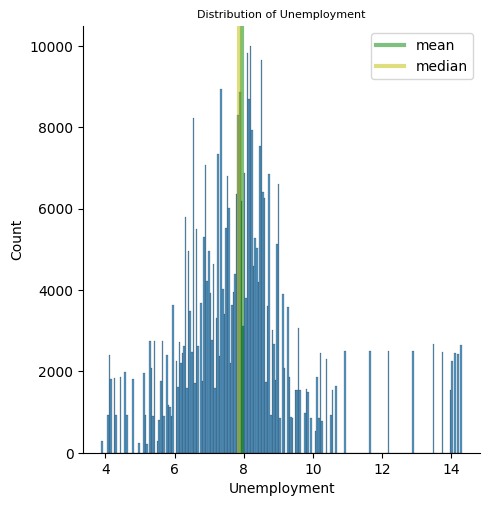

In [ ]:
sns.displot(train_df['Unemployment'], kde=False)
plt.axvline(x=train_df.Unemployment.mean(), linewidth=3, color='g', label="mean", alpha=0.5)
plt.axvline(x=train_df.Unemployment.median(), linewidth=3, color='y', label="median", alpha=0.5)

plt.xlabel('Unemployment')
plt.ylabel("Count")
plt.title("Distribution of Unemployment", size=8)
plt.legend(["mean", "median"])
plt.show()

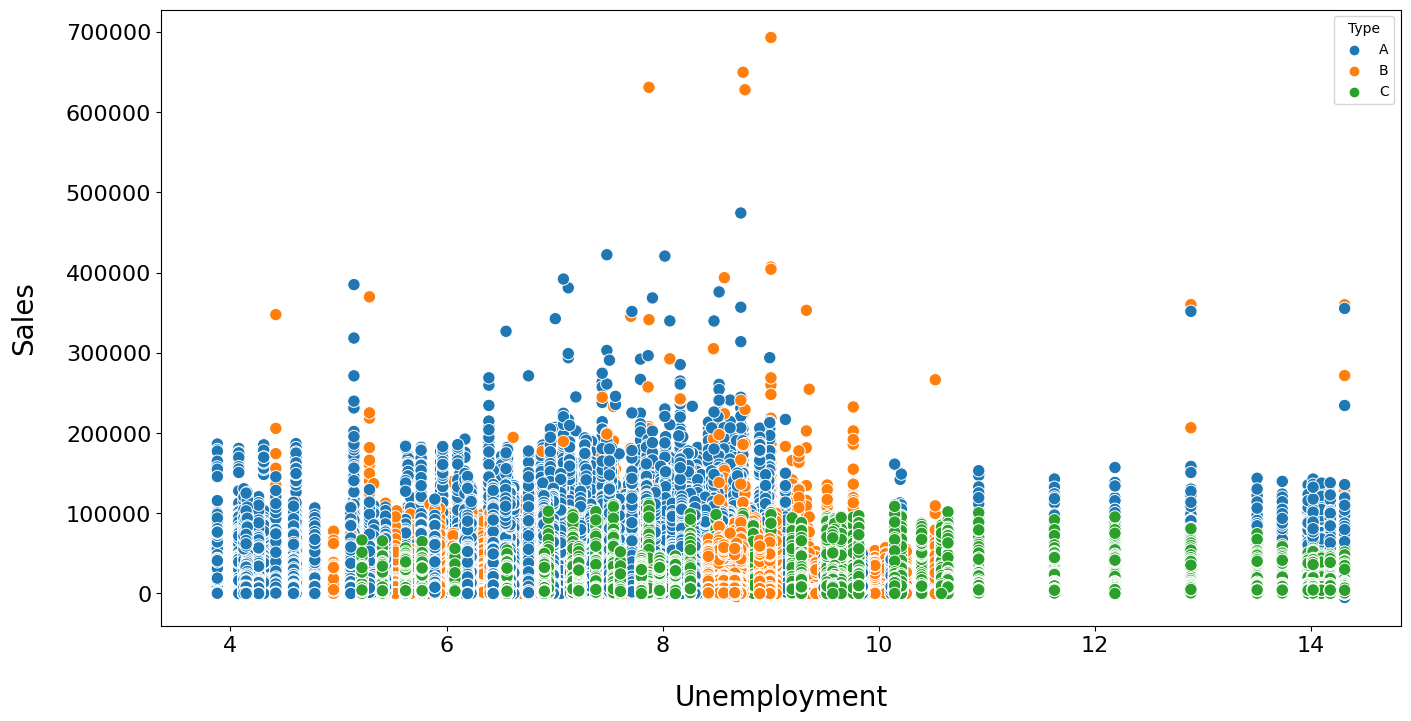

In [ ]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=train_df.Unemployment, y=train_df.Weekly_Sales, hue=train_df.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Unemployment', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

In [ ]:
px.histogram(train_plt, x='Unemployment', y ='Weekly_Sales', color='IsHoliday', marginal='box', opacity= 0.6,
             title='Unemployment rate and sales by holiday',color_discrete_sequence=['#FF6692', '#B6E880'])

# Other features relationship

In [ ]:
sizes= train_plt.groupby('Size').mean()
px.line(sizes, x = sizes.index, y = sizes.Weekly_Sales,
        title='Store size and sales')

<ipython-input-74-e9e79703a6c3>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:
store_type = pd.concat([stores['Type'], stores['Size']], axis=1)
px.box(store_type, x='Type', y='Size', color='Type',
       title='Store size and Store type',color_discrete_sequence=['#636EFA', '#EF553B', '#00CC96'])

In [ ]:
store_sale = pd.concat([stores['Type'], train_df['Weekly_Sales']], axis=1)
px.box(store_sale.dropna(), x='Type', y='Weekly_Sales', color='Type',
       title='Store type and sales',color_discrete_sequence=['#AB63FA', '#FFA15A', '#19D3F3'])

In [ ]:
depts= train_plt.groupby('Dept').mean().sort_values(by='Weekly_Sales', ascending = False)
bar=px.bar(depts, x = depts.index, y =  depts.Weekly_Sales, title='Department and sales',color=depts.Weekly_Sales)
bar.update_layout(barmode='group', xaxis={'categoryorder':'total descending'})

<ipython-input-77-14db2ff07bc7>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



# Heatmap and correlation between features


In [ ]:
storetype_values = {'A':3, 'B':2, 'C':1}
train_df['Type_Numeric'] = train_df.Type.map(storetype_values)
testing_train['Type_Numeric'] = testing_train.Type.map(storetype_values)

<ipython-input-79-4b1ce121d8f6>:5: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



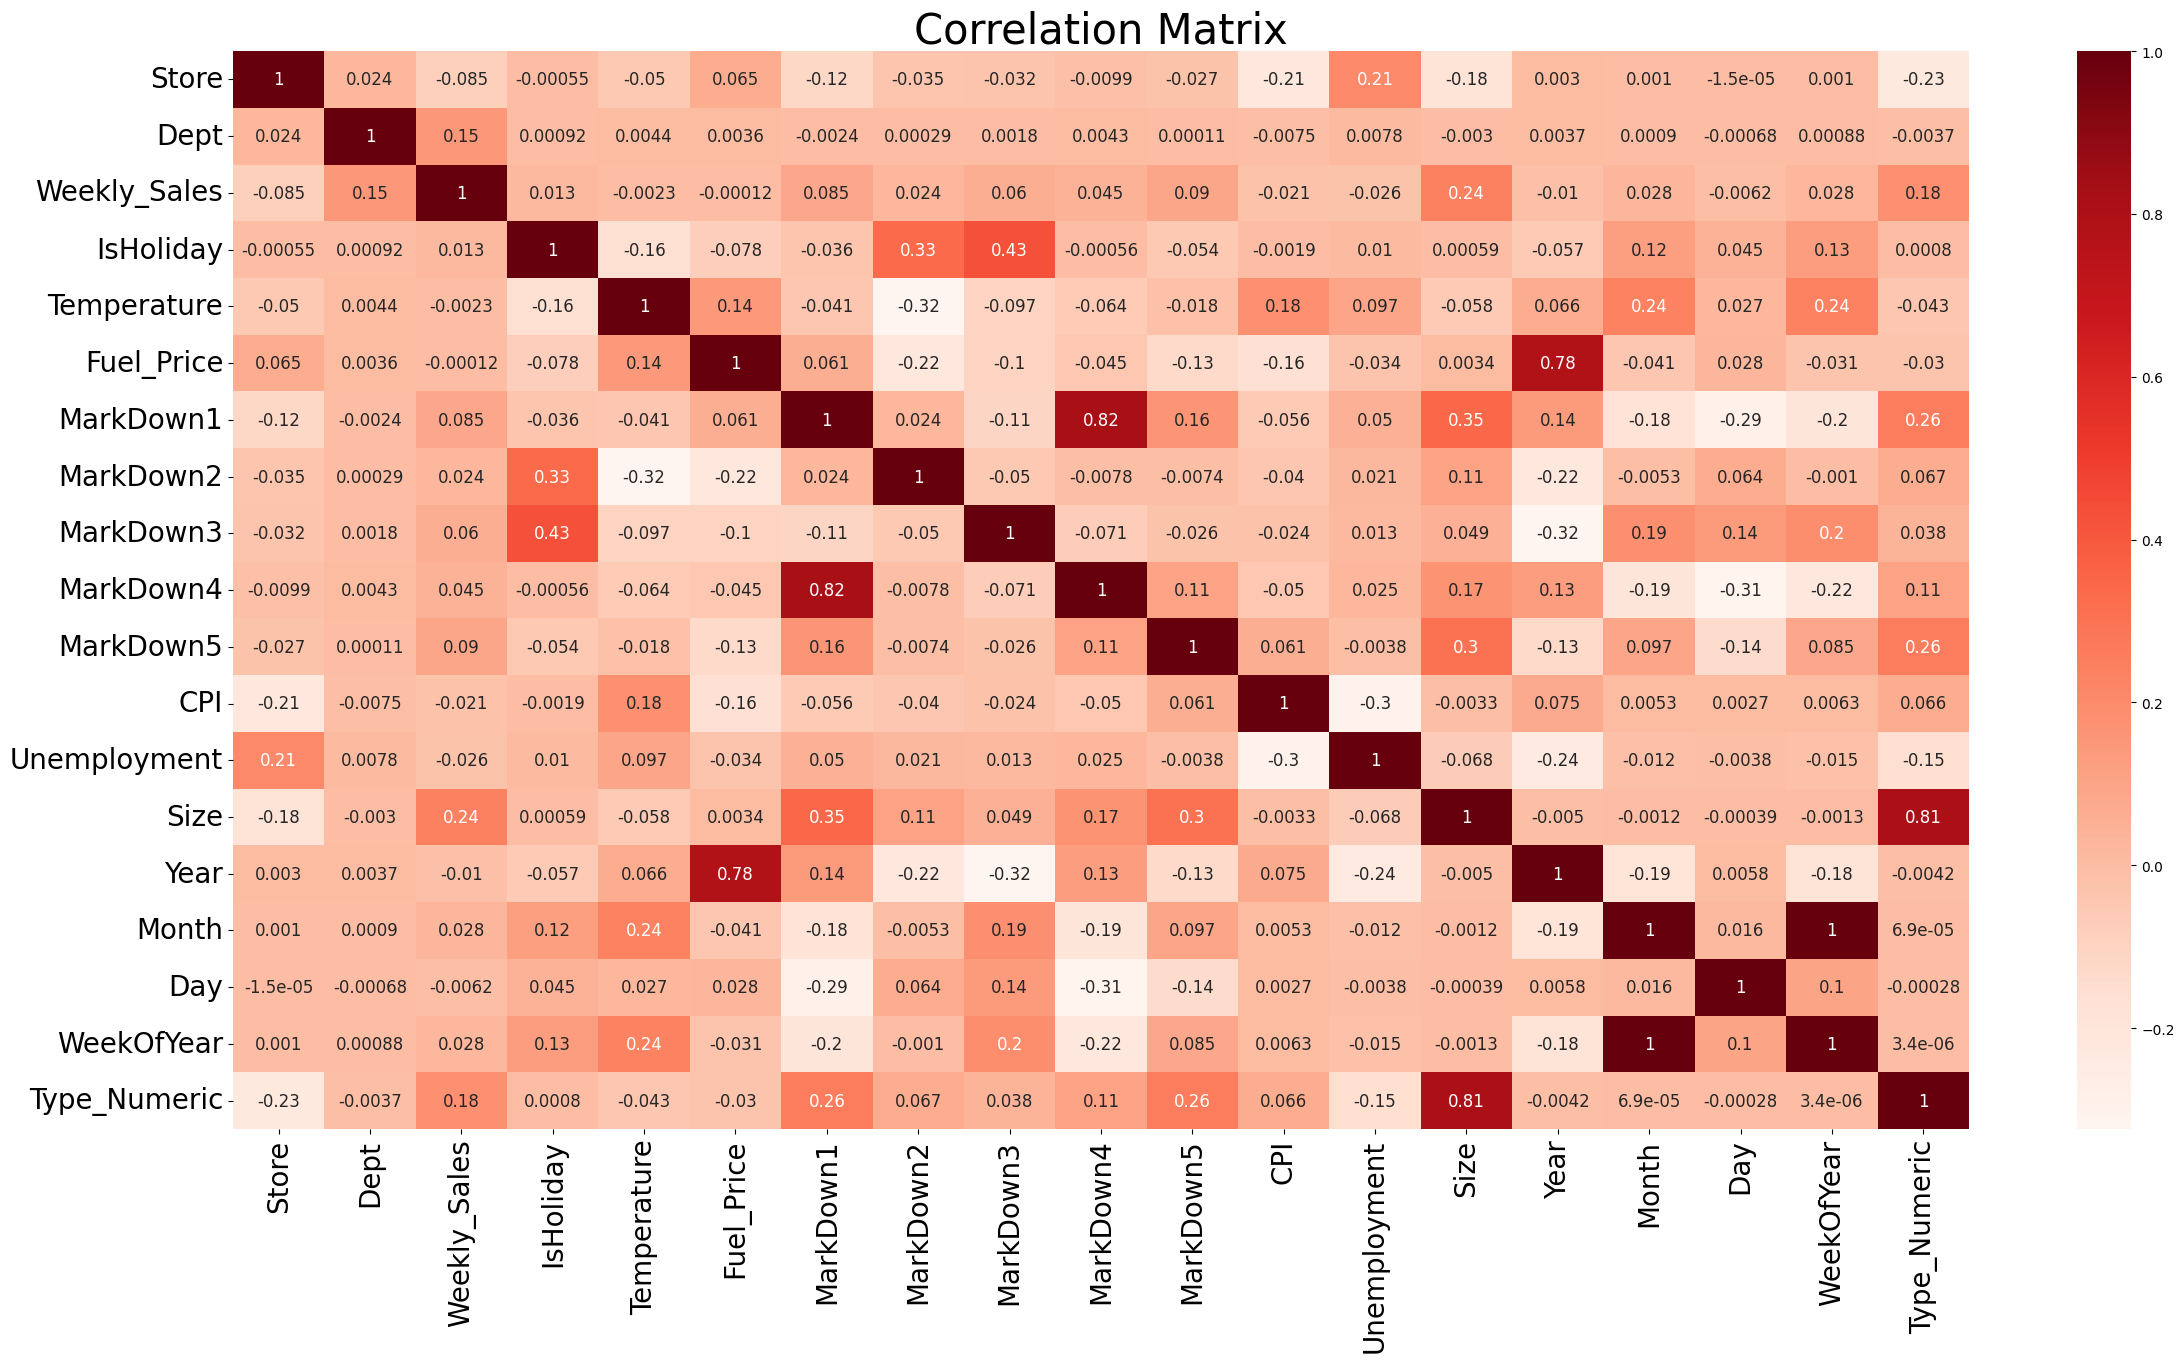

In [ ]:
plt.figure(figsize=(28,14))
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)

sns.heatmap(train_df.corr(), cmap='Reds', annot=True, annot_kws={'size':12})
plt.title('Correlation Matrix', fontsize=30);

In [ ]:
weekly_sales_corr = train_df.corr().iloc[2,:]
corr_df = pd.DataFrame(data = weekly_sales_corr, index = weekly_sales_corr.index ).sort_values (by = 'Weekly_Sales', ascending = False)
corr_df = corr_df.iloc[1:]
bar = px.bar(corr_df, x = corr_df.index, y = 'Weekly_Sales', color=corr_df.index, labels={'index':'Featues'},
             title='Feature correlation with sales',color_discrete_sequence=px.colors.qualitative.Plotly)
bar.update_traces(showlegend=False)

<ipython-input-80-8f39306da743>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

